In [1]:
import pandas as pd


file_path = 'MillionSongSubset/user_item_interactions.csv'
data = pd.read_csv(file_path)
data = data.rename(columns={data.columns[0]: 'user_id'})

data.head()

,user_id,SOFMCTW12A8C139DDA,SOXNBSR12A8C13D3E5,SOCHRXB12A8AE48069,SOASNQV12A8AE48819,SOHMWZN12A8C13C088,SOQYEDW12A6D4F8D64,SOSYMSX12A6310DFE2,SOGCDYR12AC961854A,SOYIXMY12AF72A0734,...,SOOUFTE12AB0183D19,SOJBELS12A6D4FCE9A,SOXSUIT12A6D4F48DC,SOOAHQO12A6D4FA507,SOHSILH12A58A7CA6B,SOEERUL12A8C144976,SOIZEZF12A8C13F7E9,SOVENLZ12A8C13F7DE,SOWZOIY12AB0181FD3,SORCBQY12AB0179F6A
0,00028f3cff4872bff3e9985cfa32e01a8d54e374,97.008101,96.615481,142.993438,197.536778,114.024719,163.735409,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0004cfbf3e3367f683b266f8da2610d460d02acd,0.000000,0.000000,0.000000,197.536778,0.000000,0.000000,206.931288,180.032721,143.55195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000ebc858861aca26bac9b49f650ed424cf882fc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0025bfe6248070545d23721083acd3f60451da4f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002abc31db3d2d789395e728461156f1928a5a62,0.000000,0.000000,142.993438,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Identifier les colonnes qui contiennent des données non numériques
non_numeric_columns = data.select_dtypes(include=['object']).columns

# Afficher les colonnes non numériques
non_numeric_columns

Index(['user_id'], dtype='object')

In [3]:
# Retirer la colonne 'user_id'
data_numeric = data.drop('user_id', axis=1)

# Répéter la normalisation
max_values = data_numeric.max()
non_zero_max_values = max_values.replace(0, 1)  # Remplacer les 0 par 1 pour éviter la division par zéro
normalized_data = data_numeric / non_zero_max_values

# Vérifier les premières lignes des données normalisées et leurs statistiques
normalized_data_head = normalized_data.head()
normalized_data_description = normalized_data.describe()

normalized_data_head, normalized_data_description

(   SOFMCTW12A8C139DDA  SOXNBSR12A8C13D3E5  SOCHRXB12A8AE48069  \
 0                 1.0                 1.0                 1.0   
 1                 0.0                 0.0                 0.0   
 2                 0.0                 0.0                 0.0   
 3                 0.0                 0.0                 0.0   
 4                 0.0                 0.0                 1.0   
 
    SOASNQV12A8AE48819  SOHMWZN12A8C13C088  SOQYEDW12A6D4F8D64  \
 0                 1.0                 1.0                 1.0   
 1                 1.0                 0.0                 0.0   
 2                 0.0                 0.0                 0.0   
 3                 0.0                 0.0                 0.0   
 4                 0.0                 0.0                 0.0   
 
    SOSYMSX12A6310DFE2  SOGCDYR12AC961854A  SOYIXMY12AF72A0734  \
 0                 0.0                 0.0                 0.0   
 1                 1.0                 1.0                 1.0   
 2    

In [4]:
import torch
from torch import nn
from torch.optim import Adam

# Convertir les données en Tensor PyTorch
user_item_matrix = normalized_data.values
user_item_tensor = torch.FloatTensor(user_item_matrix)

In [5]:
class MultVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(MultVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mu
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # LogVar

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Paramètres du modèle
input_dim = normalized_data.shape[1]
hidden_dim = 600 
latent_dim = 200 

# Instanciation du modèle
mult_vae = MultVAE(input_dim, hidden_dim, latent_dim)


In [6]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.optim import Adam

user_item_tensor = torch.FloatTensor(user_item_matrix)
num_epochs = 20
batch_size = 64

# Création d'un dataset et d'un DataLoader
dataset = TensorDataset(user_item_tensor, user_item_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = Adam(mult_vae.parameters(), lr=1e-3)

# Pour stocker la perte à chaque époque
losses = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    mult_vae.train()
    train_loss = 0
    for batch, _ in dataloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = mult_vae(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(dataloader.dataset)
    losses.append(avg_loss)  # Stocker la perte moyenne
    print(f'Epoch {epoch}, Loss: {avg_loss}')


Epoch 0, Loss: 114.78926438409367
Epoch 1, Loss: 42.77256236057565
Epoch 2, Loss: 39.8477884342517
Epoch 3, Loss: 37.99602833008109
Epoch 4, Loss: 37.1825614744959
Epoch 5, Loss: 36.93284216097681
Epoch 6, Loss: 36.718946716117415
Epoch 7, Loss: 36.5271511534627
Epoch 8, Loss: 36.32546276452145
Epoch 9, Loss: 36.104687978562
Epoch 10, Loss: 35.895193565008654
Epoch 11, Loss: 35.74844149130576
Epoch 12, Loss: 35.619661603875386
Epoch 13, Loss: 35.480231306776204
Epoch 14, Loss: 35.307565532405654
Epoch 15, Loss: 35.14051086049592
Epoch 16, Loss: 35.07190650615401
Epoch 17, Loss: 34.956939953197626
Epoch 18, Loss: 34.81014575863819
Epoch 19, Loss: 34.59558925684551


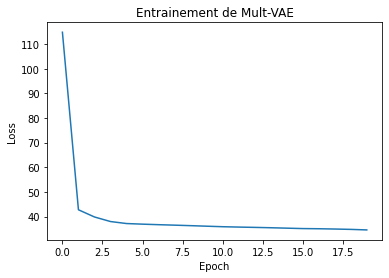

In [12]:
# Tracé du graphique de la perte
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Entrainement de Mult-VAE')
plt.show()

In [13]:
# Obtenir les prédictions pour tous les utilisateurs
user_item_matrix_pred, _, _ = mult_vae(user_item_tensor)
user_item_matrix_pred = user_item_matrix_pred.detach().numpy()

# Convertir les prédictions en DataFrame pour une manipulation facile
user_item_pred_df = pd.DataFrame(user_item_matrix_pred, index=data.index, columns=data.columns[1:])


In [14]:
def calculate_dcg(recommended_items, relevance, k):
    dcg = 0
    for i in range(k):
        item_relevance = relevance.get(recommended_items[i], 0)
        dcg += item_relevance / np.log2(i + 2)  # i+2 car l'index commence à 0 et le log de 1 est 0
    return dcg

def calculate_ndcg(recommended_items, relevance, k):
    dcg = calculate_dcg(recommended_items, relevance, k)
    idcg = calculate_dcg(sorted(recommended_items, key=lambda x: relevance.get(x, 0), reverse=True), relevance, k)
    return dcg / idcg if idcg > 0 else 0

In [15]:
import pandas as pd
import numpy as np

# Charger la matrice utilisateur-item
user_item_matrix = data

# Charger les données des chansons
songs_data_path = 'MillionSongSubset/songs_data_cleaned.csv'
df_songs = pd.read_csv(songs_data_path)

# Convertir la durée en secondes
def convert_duration_to_seconds(duration):
    if isinstance(duration, float) or isinstance(duration, int):
        return duration
    else:
        minutes, seconds = map(int, duration.split(':'))
        return minutes * 60 + seconds

df_songs['duration_in_seconds'] = df_songs['duration'].apply(convert_duration_to_seconds)

# Normaliser les données de durée
max_duration = df_songs['duration_in_seconds'].max()
min_duration = df_songs['duration_in_seconds'].min()
df_songs['normalized_duration'] = (df_songs['duration_in_seconds'] - min_duration) / (max_duration - min_duration)

# Normaliser la 'hotness'
df_songs['song_hotttnesss'] = df_songs['song_hotttnesss'].fillna(0)
max_hotness = df_songs['song_hotttnesss'].max()
min_hotness = df_songs['song_hotttnesss'].min()
df_songs['normalized_hotness'] = (df_songs['song_hotttnesss'] - min_hotness) / (max_hotness - min_hotness)

# Combiner durée normalisée et hotness normalisée pour créer une mesure de pertinence
df_songs['combined_relevance'] = (df_songs['normalized_duration'] + df_songs['normalized_hotness']) / 2

# Créer un dictionnaire de pertinence
relevance = df_songs.set_index('song_id')['combined_relevance'].to_dict()

# Transformer la matrice utilisateur-item en dictionnaire d'interactions avec pertinence normalisée
actual_interactions = {user_id: {song_id: relevance.get(song_id, 0) for song_id in user_item_matrix} for user_id in user_item_matrix.index}

# Affichage des données de pertinence normalisées
print(relevance)


{'SOEBDOO12AB01868CA': 0.053373893805309734, 'SOMIPLK12AB017C7B2': 0.3993667971604143, 'SOICNXT12A8BEE958B': 0.1725290973077113, 'SOHRKRG12A6310F103': 0.43689504273645796, 'SOVCWYN12AB0181888': 0.21501926487421452, 'SOGMESY12A67020F25': 0.3798310454846505, 'SOKSIRH12AB017FDCB': 0.18137865482983517, 'SOAZSIZ12AB018AF81': 0.32344736825113457, 'SOUSNTL12A6D4F7CE9': 0.09292035398230089, 'SOHQLJI12A6D4F76F7': 0.19659793960960664, 'SOHTGJW12A58A7D7D3': 0.41387056761510116, 'SOIKXDG12A8C13E7E1': 0.3561503394599872, 'SOAKCVK12A67020429': 0.20021256359925887, 'SOBPYWO12A8C133A1A': 0.2320553393989832, 'SOPBJAX12A6310E86F': 0.2834335245436975, 'SOTWAJH12A6D4FA397': 0.24182777235011801, 'SOQWDSR12AB01850B6': 0.055862831858407076, 'SOGDLTS12A8C135A9B': 0.5190837694375677, 'SOSFJWB12AB018906D': 0.3069963470507045, 'SOCLPMP12A81C2354B': 0.2718971233115603, 'SOGFHXF12A8C136B2A': 0.29659592569032955, 'SOFYSKU12A8C13A72B': 0.27951970426067463, 'SOJGCBK12AB01884D3': 0.3281679150556193, 'SOZUQAZ12A81C21E0

In [16]:
ndcg_scores = []
k = 100

for user_id in user_item_pred_df.index:
    recommended_items = user_item_pred_df.loc[user_id].sort_values(ascending=False).index.tolist()[:k]
    ndcg_score = calculate_ndcg(recommended_items, relevance, k)
    ndcg_scores.append(ndcg_score)

# Calculate NDCG score
als_average_ndcg = np.mean(ndcg_scores)
als_variance_ndcg = np.var(ndcg_scores)
print(f"Mean : {als_average_ndcg:.5f} - Variance : {als_variance_ndcg:.5f}")

Mean : 0.95535 - Variance : 0.00006
